# Exploratory Data Analysis on Seller Features

**Goal:**
- ❓ Inspect each seller features to gain an initial understanding of its characertistics
- ❓ Find sellers who have repeatedly been underperforming vs others, and understand why.


In [6]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# Import Modules

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

In [9]:
from olist.data import Olist
from olist.order import Order
from olist.seller import Seller

In [10]:
sellers = Seller().get_training_data()
sellers.head()

,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,share_of_one_stars,share_of_five_stars,review_score,cost_of_reviews,n_orders,quantity,quantity_per_order,sales,revenues,profits
0,3442f8959a84dea7ee197c632cb2df15,campinas,SP,0.000000,13.018588,2017-05-05 16:25:11,2017-08-30 12:50:19,4.0,0.333333,0.333333,3.00,140,3,3,1.000,218.70,341.870,201.870
1,d1b65fc7debc3361ea86b5f14c68d2e2,mogi guacu,SP,0.000000,9.065716,2017-03-29 02:10:34,2018-06-06 20:15:21,14.0,0.050000,0.725000,4.55,240,40,41,1.025,11703.07,2290.307,2050.307
2,ce3ad9de960102d0677a81f5d0bb7b2d,rio de janeiro,RJ,0.000000,4.042292,2018-07-30 12:44:49,2018-07-30 12:44:49,0.0,0.000000,1.000000,5.00,0,1,1,1.000,158.00,15.800,15.800
3,c0f3eea2e14555b6faeea3dd58c1b1c3,sao paulo,SP,0.000000,5.667187,2018-08-03 00:44:08,2018-08-03 00:44:08,0.0,0.000000,1.000000,5.00,0,1,1,1.000,79.99,7.999,7.999
4,51a04a8a6bdcb23deccc82b0b80742cf,braganca paulista,SP,3.353727,35.314861,2017-11-14 12:15:25,2017-11-14 12:15:25,0.0,1.000000,0.000000,1.00,100,1,1,1.000,167.99,16.799,-83.201


## 1 - Feature Inspection

- How does the distribution of this variable look like ❓
- Are there any outliers  ❓

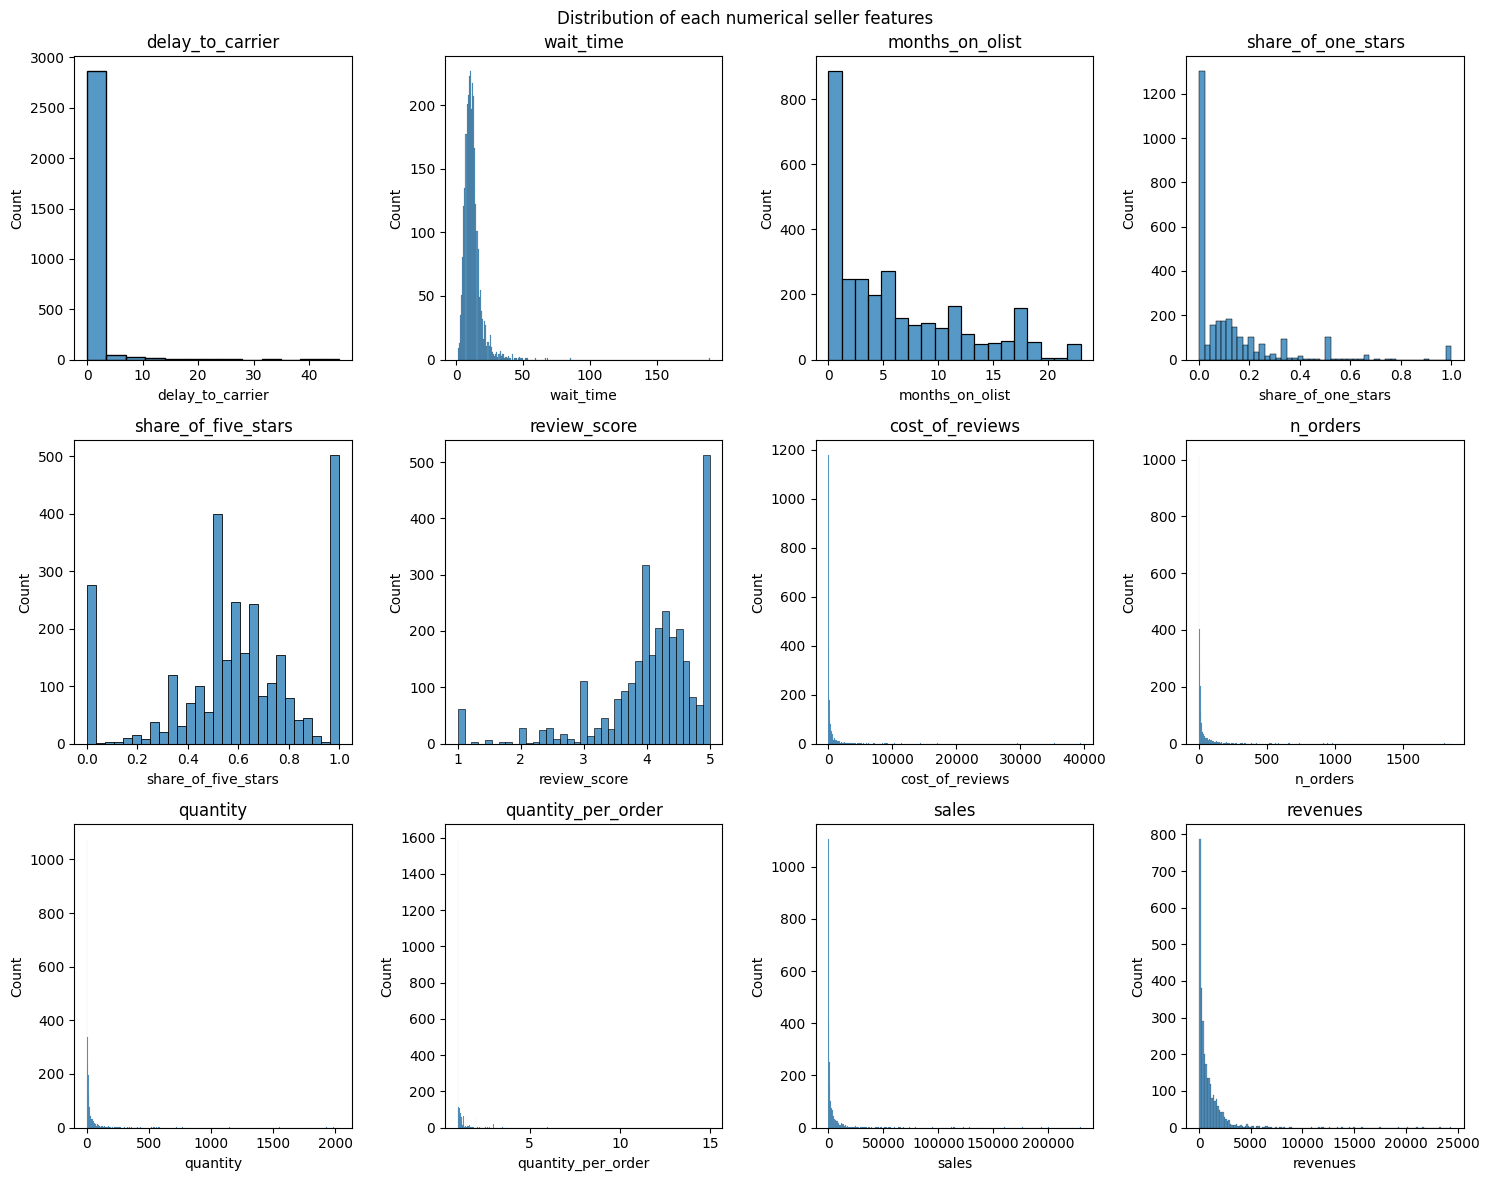

In [11]:
features = ['delay_to_carrier', 'wait_time','months_on_olist', 'share_of_one_stars', 'share_of_five_stars',
               'review_score', 'cost_of_reviews', 'n_orders', 'quantity','quantity_per_order', 'sales','revenues']
fig,axs = plt.subplots(3,4,figsize=(15,12))
axs = axs.flatten()
for i, col in enumerate(features):
    sns.histplot(sellers.loc[:,col],ax=axs[i],kde=False)
    axs[i].set_title(col)
plt.suptitle("Distribution of each numerical seller features")
plt.tight_layout()

💡There seems to be a group of sellers which stands out for having very low review scores.

(-0.1, 1.1)

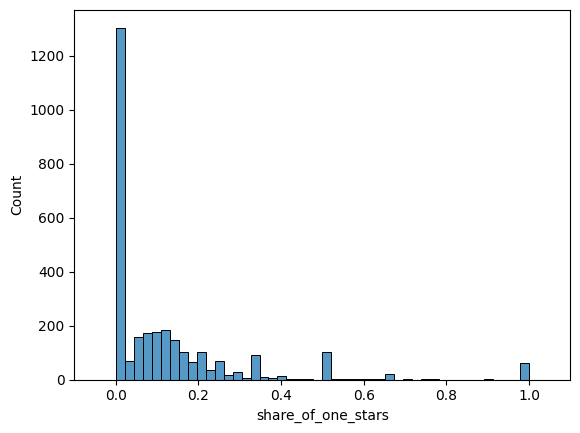

In [12]:
sns.histplot(data=sellers,x='share_of_one_stars')
plt.xlim(-0.1,1.1)

In [13]:
import plotly.io as pio
pio.renderers.default = 'notebook'

In [24]:
import plotly.express as px
fig = px.scatter(data_frame = sellers,
    x="delay_to_carrier",
    y="wait_time",
    size="sales",
    color="review_score",
    size_max = 60,
    opacity = 0.5,
    hover_name="seller_id"
)
fig.update_layout(title='Scatter Plot of Wait Time vs. Delay to Carrier')

fig.show(renderer='iframe')

From here, you can kind of see who are the worst sellers.

In [15]:
sellers.select_dtypes(include=np.number).columns

Index(['delay_to_carrier', 'wait_time', 'months_on_olist',
       'share_of_one_stars', 'share_of_five_stars', 'review_score',
       'cost_of_reviews', 'n_orders', 'quantity', 'quantity_per_order',
       'sales', 'revenues', 'profits'],
      dtype='object')

<AxesSubplot: >

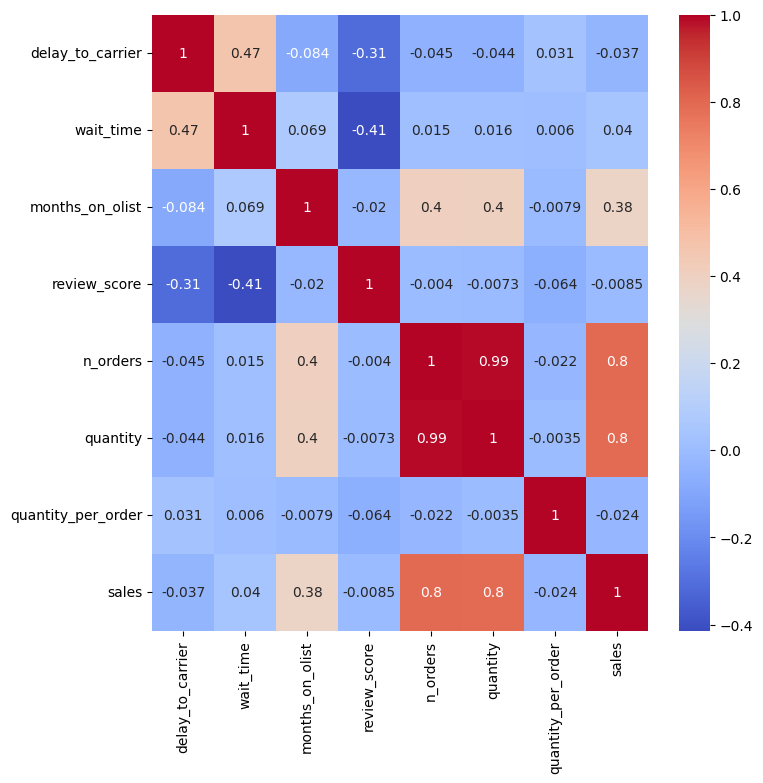

In [16]:
plt.figure(figsize = (8, 8))
corr_feat = ['delay_to_carrier', 'wait_time', 'months_on_olist','review_score','n_orders', 'quantity', 'quantity_per_order','sales']

sns.heatmap(
    sellers.loc[:,corr_feat].corr(), 
    cmap = 'coolwarm', 
    annot = True, 
    annot_kws = {"size": 10}
)

## 2 - Multivariate Regression
model the impact of various features on review_score with multivariate OLS in statsmodels

***Standardizing the features***

In [17]:
from sklearn.preprocessing import StandardScaler
num_col = sellers.select_dtypes(include=np.number).columns
scaler = StandardScaler()
std_sellers = pd.DataFrame(scaler.fit_transform(sellers.select_dtypes(include=np.number)),
            columns = num_col)
std_sellers.head()

,delay_to_carrier,wait_time,months_on_olist,share_of_one_stars,share_of_five_stars,review_score,cost_of_reviews,n_orders,quantity,quantity_per_order,sales,revenues,profits
0,-0.168002,0.124387,-0.337986,1.125101,-0.939107,-1.374517,-0.214632,-0.286013,-0.287234,-0.358006,-0.306577,-0.359573,-0.153247
1,-0.168002,-0.434873,1.330572,-0.375409,0.466147,0.559642,-0.161689,0.059250,0.025539,-0.301121,0.502783,0.813844,1.324705
2,-0.168002,-1.145597,-1.005409,-0.640204,1.452814,1.121172,-0.288752,-0.304676,-0.303696,-0.358006,-0.310854,-0.555944,-0.302022
3,-0.168002,-0.915703,-1.005409,-0.640204,1.452814,1.121172,-0.288752,-0.304676,-0.303696,-0.358006,-0.316352,-0.560642,-0.308260
4,1.293046,3.278906,-1.005409,4.655712,-2.135068,-3.870205,-0.235809,-0.304676,-0.303696,-0.358006,-0.310150,-0.555342,-0.381180


In [18]:
features = ['delay_to_carrier', 'wait_time', 'months_on_olist','n_orders', 'quantity', 'quantity_per_order']
model = smf.ols(formula=f"review_score ~ {'+ '.join(features)}", data=std_sellers).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           review_score   R-squared:                       0.194
Model:                            OLS   Adj. R-squared:                  0.193
Method:                 Least Squares   F-statistic:                     119.0
Date:                Tue, 15 Oct 2024   Prob (F-statistic):          5.49e-135
Time:                        12:53:46   Log-Likelihood:                -3889.5
No. Observations:                2967   AIC:                             7793.
Df Residuals:                    2960   BIC:                             7835.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            6.55e-16      0.016   3.97e-14      1.000      -0.032       0.032
delay_to_carrier      -0.1551      0.019     -8.245      0.000      -0.192      -0.118
wait_time             -0.3412      0.019    -18.165      0.000      -0.378      -0.304
months_on_olist       -0.0089      0.018     -0.491      0.624      -0.045       0.027
n_orders               0.1375      0.147      0.939      0.348      -0.150       0.425
quantity              -0.1421      0.146     -0.972      0.331      -0.429       0.145
quantity_per_order    -0.0542      0.017     -3.237      0.001      -0.087      -0.021
==============================================================================
Omnibus:                      844.001   Durbin-Watson:                   2.046
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2971.341
Skew:                          -1.392   Prob(JB):                         0.00
Kurtosis:                       7.035   Cond. No.                         18.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

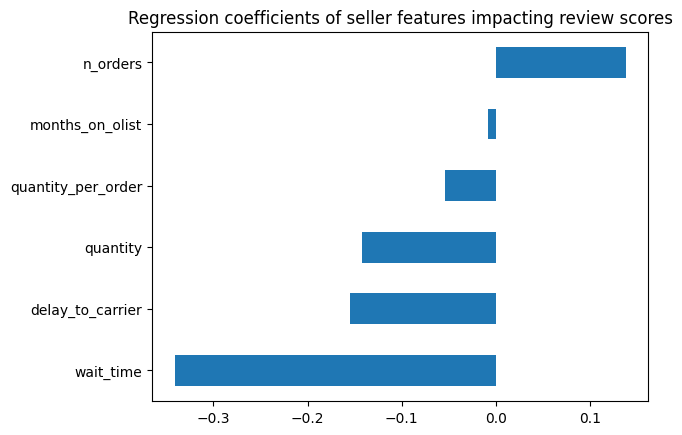

In [23]:
model.params[1:].sort_values().plot(kind='barh')
plt.title('Regression coefficients of seller features impacting review scores')
plt.show()

🔎 Interpretation:
- `months_on_olist`,`n_orders`,and `quantity` are not statistically significant
- `wait_time` and `delay_to_carrier` seems to have a negative impact on review scores

## 3 - Adding categorical feature (seller_state) to analysis 

In [19]:
sellers['seller_state'].unique()

array(['SP', 'RJ', 'PE', 'PR', 'GO', 'SC', 'BA', 'DF', 'RS', 'MG', 'RN',
       'MT', 'CE', 'PB', 'ES', 'RO', 'PI', 'MS', 'SE', 'MA', 'AM', 'PA'],
      dtype=object)

In [20]:
sellers.loc[:,['review_score','seller_state','n_orders']
                    ].groupby(by='seller_state').agg({'review_score':'mean',
                                                      'n_orders':'sum'}).sort_values(by='review_score')

,review_score,n_orders
seller_state,,
AM,2.333333,3
CE,3.679398,90
SE,3.850000,9
RO,3.854167,14
MA,3.992288,392
DF,4.032114,824
SP,4.072842,70841
PI,4.083333,12
BA,4.095019,568


In [21]:
model2 = smf.ols(formula = 'review_score ~ C(seller_state)',data=sellers).fit()
model2.params

from olist.utils import return_significative_coef
return_significative_coef(model2).sort_values(by='coef').head(10)

,variable,p_value,coef
3,C(seller_state)[T.DF],0.037168,1.698781
21,C(seller_state)[T.SP],0.030123,1.739509
1,C(seller_state)[T.BA],0.032503,1.761685
15,C(seller_state)[T.RJ],0.028171,1.765621
12,C(seller_state)[T.PE],0.034163,1.790505
7,C(seller_state)[T.MG],0.024353,1.809492
5,C(seller_state)[T.GO],0.025828,1.810196
18,C(seller_state)[T.RS],0.024153,1.815430
14,C(seller_state)[T.PR],0.022771,1.829067
19,C(seller_state)[T.SC],0.022605,1.833534


☝️ Some states have significantly better reviews than others on average.

🤔 We are not sure if it is due to some lower quantity_per_order, lower wait_time, or delay_to_carrier. 

❓ We will try to isolate the impact of the seller_state from the rest by adding other continuous features to your OLS until seller_states is no longer statistically siginificant.

In [24]:
# Use C(variable) in the formula
formula = 'review_score ~  sales + quantity + quantity_per_order + C(seller_state)'
model3 = smf.ols(formula=formula, data=sellers).fit()
return_significative_coef(model3).head(5+1)

,variable,p_value,coef
0,Intercept,0.002227,2.451728
16,C(seller_state)[T.RN],0.014267,2.149534
4,C(seller_state)[T.ES],0.010618,2.092058
8,C(seller_state)[T.MS],0.025759,1.955813
11,C(seller_state)[T.PB],0.025146,1.936537
9,C(seller_state)[T.MT],0.034190,1.895819


In [25]:
formula = 'review_score ~  wait_time + C(seller_state)'
model4 = smf.ols(formula=formula, data=sellers).fit()
return_significative_coef(model4).head()

,variable,p_value,coef
0,Intercept,3.895321e-10,4.612005
22,wait_time,3.171865e-124,-0.047630


🔎 Interpretation:

After adding wait_time to our analysis, none of the 22 dummy variables is_seller_state_xx are statistically signigicant:

Given our small dataset (most states have a very limited number of sellers):

- We cannot conclude that "some states are inherently better than other for reasons that would be independent of the wait_time"
- In other words, we cannot reject the hypothesis that "seller_state has no impact on review_score, other than through wait_time"